In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

plt.style.use('ggplot')

In [ ]:
time = np.linspace(0, 10, 1000)

position = (
    np.cos(2 * time)
    * np.exp(-0.1 * time)
    + np.random.normal(0, 0.1, size=(1000,))
)

[Text(0.5, 0, 'Time [s]'), Text(0, 0.5, 'Position [cm]')]

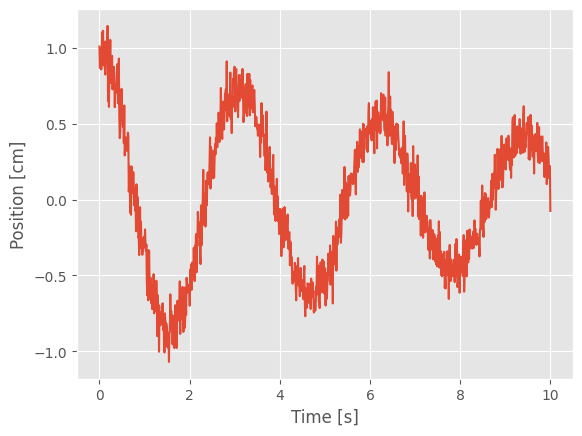

In [ ]:
fig, ax = plt.subplots()
ax.plot(time, position)
ax.set(xlabel='Time [s]', ylabel='Position [cm]')

* Uso machine learning para solucionar el problema. Quiero encontrar una función para encontrar la posición en cada segundo del tiempo. Esto se le conoce como analisis de series de tiempo.
* Predigo con datos pasados el futuro.
* Realmente no me interesa el tiempo, trabajo el con muestras. Trabajo con conversiones directas.

[Text(0.5, 0, 'Sample'), Text(0, 0.5, 'Position [cm]')]

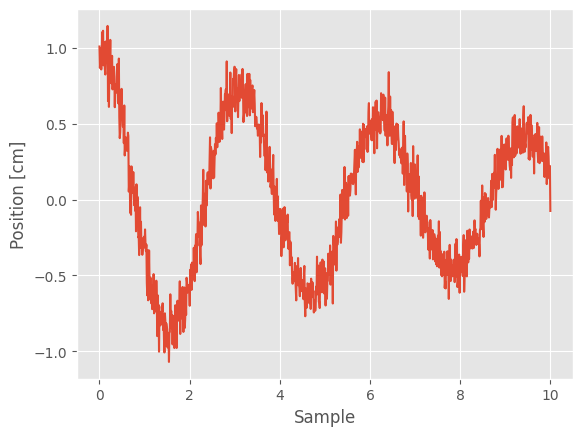

In [ ]:
fig, ax = plt.subplots()
ax.plot(time, position)
ax.set(xlabel='Sample', ylabel='Position [cm]')

In [ ]:
test_size = 0.3
n_train = int(position.size * (1 - test_size))
train, test = position[:n_train], position[n_train:]

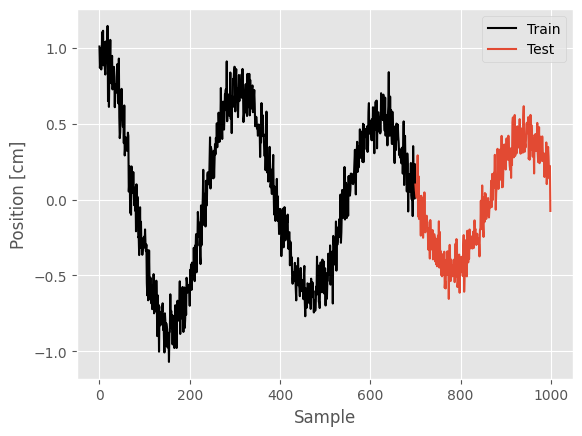

In [ ]:
fig, ax = plt.subplots()
ax.plot(train, label='Train', color='Black')
ax.plot(np.arange(n_train, position.size), test, label='Test')
ax.set(xlabel='Sample', ylabel='Position [cm]')
ax.legend()

* Vamos a ver un enfoque autoregresivo aplicado al machine learning. Este enfoque tiene una conotación enfocada hacia los modelos. Auto=predigo variables sobre si mismas. (Desde la variable trato de predecir la misma variable en otro instante de tiempo)

In [ ]:
# Partimos la secuencia en ventanas
def get_windows(time_series, window_size):
  features = []
  labels = []

  for i in range(time_series.size - window_size - 1):
    features.append(time_series[i: i + window_size].reshape(1, -1))
    labels.append(time_series[i + window_size])

  return np.concatenate(features, axis=0), np.array(labels)

In [ ]:
features_train, labels_train = get_windows(train, 30)
features_test, labels_test = get_windows(test, 30)

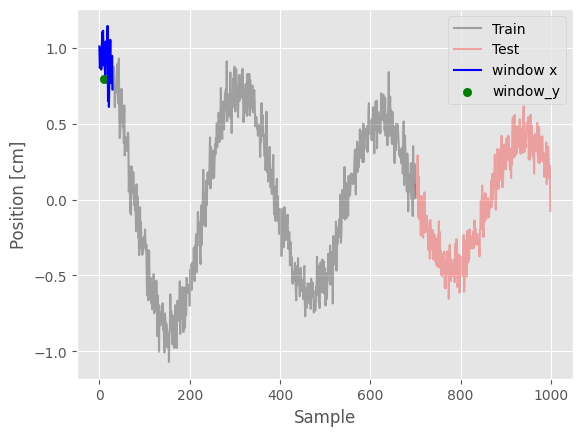

In [ ]:
fig, ax = plt.subplots()
ax.plot(train, label='Train', color='black', alpha=0.3)
ax.plot(
    np.arange(n_train, position.size),
    test, label='Test',
    color='red',
    alpha=0.3
    )

ax.plot(features_train[0], color='blue', label='window x')
ax.scatter([10], labels_train[0], color='g', label='window_y')
ax.set(xlabel='Sample', ylabel='Position [cm]')
ax.legend()



In [ ]:
features_train.shape

(669, 30)

In [ ]:
labels_train.shape

(669,)

In [ ]:
cv = TimeSeriesSplit(n_splits=5) # max_train_size=20 (utiliza las ultimas 20 ventanas)

In [ ]:
# Por experiencia/teoria puedo ver/saber que el comportamiento es exponencial,
# por lo tanto usaremos esos parametros para ver el comportamiento del modelo
param_grid = {
    "gamma": [0.01, 0.1, 1.0, 10.0, 100.0,],
    "C": [0.01, 0.1, 1.0, 10.0, 100.0,],
}

In [ ]:
# Se toma cada uno de los gamma y los C para entrenar el modelo 5 veces
gs = GridSearchCV(
    estimator=SVR(),
    param_grid=param_grid,
    cv=cv,
)

In [ ]:
gs.fit(features_train, labels_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SVR(),
             param_grid={'C': [0.01, 0.1, 1.0, 10.0, 100.0],
                         'gamma': [0.01, 0.1, 1.0, 10.0, 100.0]})

In [ ]:
5 * 5 * 5

125

In [ ]:
results = pd.DataFrame(gs.cv_results_)

results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.020140,0.010988,0.006958,0.002138,0.01,0.01,"{'C': 0.01, 'gamma': 0.01}",0.060781,-17.981788,0.374910,0.668804,-0.233320,-3.422122,7.286097,14
1,0.011547,0.007351,0.004778,0.001565,0.01,0.1,"{'C': 0.01, 'gamma': 0.1}",0.066564,-11.295969,0.741301,0.793426,0.531674,-1.832601,4.738627,13
2,0.014402,0.009473,0.005448,0.001792,0.01,1.0,"{'C': 0.01, 'gamma': 1.0}",-0.504226,-31.091076,0.039654,0.708449,-0.941309,-6.357701,12.378990,15
3,0.017373,0.012426,0.006310,0.002426,0.01,10.0,"{'C': 0.01, 'gamma': 10.0}",-0.571366,-42.582372,-1.343071,-0.034507,-8.214634,-10.549190,16.287683,24
4,0.018156,0.013309,0.006692,0.002741,0.01,100.0,"{'C': 0.01, 'gamma': 100.0}",-0.571253,-42.582296,-1.344226,-0.039905,-8.230814,-10.553699,16.286377,25
5,0.009121,0.005815,0.004058,0.001611,0.1,0.01,"{'C': 0.1, 'gamma': 0.01}",0.402949,-1.531313,0.817177,0.822458,0.589823,0.220219,0.889597,6
6,0.009625,0.006550,0.004114,0.002209,0.1,0.1,"{'C': 0.1, 'gamma': 0.1}",0.367251,-1.617288,0.890317,0.895101,0.623492,0.231775,0.944935,5
7,0.009632,0.005977,0.003670,0.001025,0.1,1.0,"{'C': 0.1, 'gamma': 1.0}",0.094777,-10.158445,0.899733,0.891363,0.587034,-1.537108,4.320605,12
8,0.017659,0.012626,0.006247,0.002521,0.1,10.0,"{'C': 0.1, 'gamma': 10.0}",-0.627377,-42.445190,-1.401472,0.008449,-7.838668,-10.460852,16.237300,22
9,0.018211,0.012799,0.006771,0.002738,0.1,100.0,"{'C': 0.1, 'gamma': 100.0}",-0.626952,-42.524437,-1.419381,-0.045418,-7.994773,-10.522192,16.254668,23


In [ ]:
results.sort_values(
    by='mean_test_score',
    ascending=False,
).head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,0.016157,0.011134,0.00416,0.00168,10.0,0.01,"{'C': 10.0, 'gamma': 0.01}",0.435621,0.44131,0.867965,0.90298,0.59728,0.649031,0.201887,1


In [ ]:
best_model = gs.best_estimator_

best_model

SVR(C=10.0, gamma=0.01)

In [ ]:
y_pred = best_model.predict(features_test)

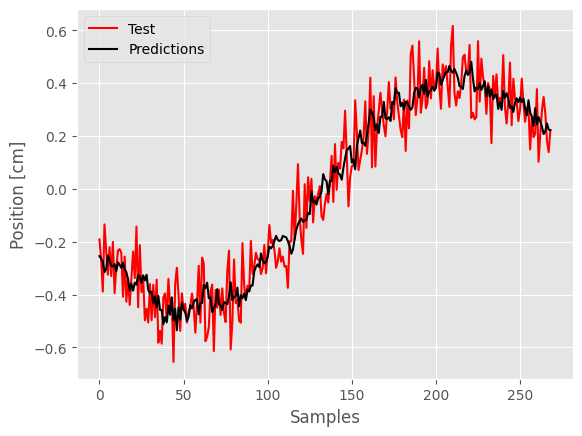

In [ ]:
fig, ax = plt.subplots()
ax.plot(labels_test, label='Test', color='r')
ax.plot(y_pred, label='Predictions', color='k')
ax.set(xlabel='Samples', ylabel='Position [cm]')
ax.legend()

**Ahora usaremos forecasting**

Generamos varios valores futuros con una muestra inicial. Generando predicciones sobre las predicciones del modelo.

In [ ]:
def forecast(model, window, n_samples):
  predictions = []
  for sample in range(n_samples):
    y_pred = model.predict(window)
    predictions.append(y_pred)
    window = np.roll(window, (0, -1))
    window[0, -1] = y_pred

  return np.array(predictions)

In [ ]:
# Que hace el metodo roll de numpy?
x = np.arange(10).reshape(1, -1)
x

array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [ ]:
np.roll(x, (0, -1))


array([[1, 2, 3, 4, 5, 6, 7, 8, 9, 0]])

In [ ]:
np.roll(x, (2, 1))

array([[7, 8, 9, 0, 1, 2, 3, 4, 5, 6]])

In [ ]:
y_pred = forecast(best_model, features_test[[0]], 300)

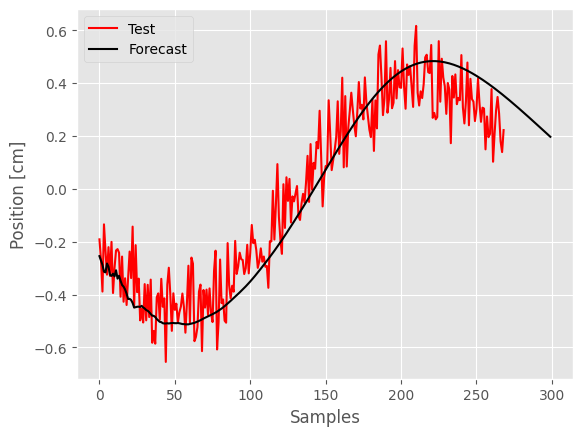

In [ ]:
fig, ax = plt.subplots()
ax.plot(labels_test, label='Test', color='r')
ax.plot(y_pred, label='Forecast', color='k')
ax.set(xlabel='Samples', ylabel='Position [cm]')
ax.legend()

Se observa un muy buen comportamiento.
Se observan errores acumulados, si alguna predicción fue erronea las predicciones de ahi en adelante se van a ver aumentadas.